# Classically Constructing Betti Number Normalization Graphs from Intrusion Data for Anomaly Detection

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import glob
import os
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from gudhi import SimplexTree
import pickle
from numpy.linalg import norm
import numpy as np

## In this notebook we are extracting network data (courtesy of University of New Brunswick--a realistic, well-known cyber defense dataset with a wide variety of simulated network attacks. More info here https://www.unb.ca/cic/datasets/ids-2018.html) and binning it in 5-minute increments to create simplicial complexes for betti number computation for advanced intrusion detection analysis.

# Step 1: Parse and Preprocess Traffic Data

Construct graphs such that the source node (source IP) connects to the destination node (dest IP) by an edge weighted by the number of bytes/packet weight passed between them.

Group by 5-minute windows

In [3]:
# Read all CSV files (or just one if testing)
# BCCC-CIC-CSE-IDS2018/Friday-16-02-2018/friday_16_02_2018_benign_part2/friday_16_02_2018_benign_part2.csv
df = dd.read_csv("botnet_sorted.csv",
                #  parse_dates=['timestamp'],
                 assume_missing=True,
                 dtype={'delta_start': 'object', 'handshake_duration': 'object'})

# # Set timestamp as index for time-based resampling
# df = df.set_index('timestamp')

# Step 2: Convert timestamp manually (after reading)
df['timestamp'] = dd.to_datetime(df['timestamp'], errors='coerce')

# Step 3: Drop rows where timestamp couldn't be parsed
df = df.dropna(subset=['timestamp'])

# Step 4: Set timestamp as index
df = df.set_index('timestamp')

# Keep only required columns to save memory
# df = df[["src_ip", "src_port", "dst_ip", "dst_port", "total_payload_bytes"]]


with ProgressBar():
    df_pd = df.compute()



# df = dd.read_csv("BCCC-CIC-CSE-IDS2018/**/*.csv", parse_dates=['timestamp'], assume_missing=True)
# df['timestamp'] = dd.to_datetime(df['timestamp'], errors='coerce')
# df = df.set_index('timestamp')
# grouped = df.groupby(pd.Grouper(freq='5Min')).sum()
# result = grouped.compute() 


# # Only load needed columns (if applicable)
# usecols = ['timestamp', 'src_ip', 'dst_ip', 'src_port', 'dst_port', 'total_payload_bytes'] 

# # Use chunked reading
# chunks = pd.read_csv(
#     "BCCC-CIC-CSE-IDS2018/Friday-02-03-2018/friday_02_03_2018_bot/friday_02_03_2018_bot.csv",
#     usecols=usecols,
#     parse_dates=['timestamp'],
#     chunksize=3_000_000,  # Adjust based on available RAM
#     low_memory=True
# )

# # Process each chunk
# chunk_list = []
# for chunk in chunks:
#     chunk.set_index('timestamp', inplace=True)
#     chunk_list.append(chunk)

# # Concatenate all processed chunks
# df = pd.concat(chunk_list)

# # Group after full load
# grouped = df.groupby(pd.Grouper(freq='5Min'))


# df = pd.read_csv("BCCC-CIC-CSE-IDS2018/Friday-02-03-2018/friday_02_03_2018_bot/friday_02_03_2018_bot.csv")
# df['timestamp'] = pd.to_datetime(df['timestamp'])

# df.set_index('timestamp', inplace=True)
# grouped = df.groupby(pd.Grouper(freq='5Min'))

[########################################] | 100% Completed | 20.60 s
[########################################] | 100% Completed | 18.60 s


In [3]:
# benign_df["label"] = "benign"
# attack_df["label"] = "attack"

# # Combine them
# combined_df = pd.concat([benign_df, attack_df])

Construct graphs

In [5]:
graphs = []
for window_start, group in df_pd.groupby(pd.Grouper(freq='5Min')):
    G = nx.Graph()
    for _, row in group.iterrows():
        src = f"{row['src_ip']}"
        dst = f"{row['dst_ip']}"
        weight = row['total_payload_bytes']
        if weight > 0:
            G.add_edge(src, dst, weight=weight)
    graphs.append((window_start, G))

# save graphs for easy retrieval later
with open("bot_graphs.pkl", "wb") as f:
    pickle.dump(graphs, f)

Visualize one of the graphs

In [1]:
# bot_df = pd.read_csv("BCCC-CIC-CSE-IDS2018/Friday-02-03-2018/friday_02_03_2018_bot/friday_02_03_2018_bot.csv", parse_dates=["timestamp"])
# benign_df = pd.read_csv("BCCC-CIC-CSE-IDS2018/Friday-02-03-2018/friday_02_03_2018_benign/friday_02_03_2018_benign.csv", parse_dates=["timestamp"])
# print(bot_df["timestamp"].min(), bot_df["timestamp"].max())
# print(benign_df["timestamp"].min(), benign_df["timestamp"].max())

Window start: 2018-02-27 16:25:00
Number of nodes: 21
Number of edges: 20
Number of Graphs: 1013


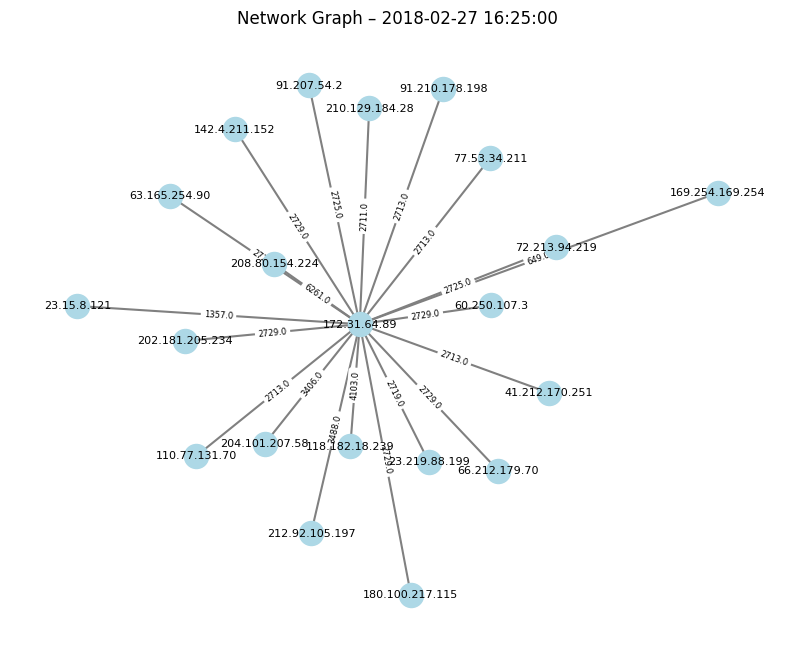

In [6]:
# with open("graphs.pkl", "rb") as f:
#     graphs = pickle.load(f)

timestamp, G = graphs[110]
print(f"Window start: {timestamp}")
print(f"Number of nodes: {len(G.nodes)}")
print(f"Number of edges: {len(G.edges)}")
print(f"Number of Graphs: {len(graphs)}")

plt.figure(figsize=(10, 8))

# Choose a layout
pos = nx.spring_layout(G, seed=42)  # consistent layout
edge_labels = {(u, v): f"{d['weight']}" for u, v, d in G.edges(data=True)}

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_size=300, node_color='lightblue')
nx.draw_networkx_edges(G, pos, width=1.5, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=8)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)

plt.title(f"Network Graph – {timestamp}")
plt.axis('off')
plt.show()


# Step 2: Lift Graphs into Simplicial Complexes

Convert triangles in the graphs into 2-simplices

In [13]:
def build_complex_from_graph(G, top_percentile=0.8):
    st = SimplexTree()

    node_map = {node: i for i, node in enumerate(G.nodes)}
    for node in G.nodes:
        st.insert([node_map[node]], filtration=0)

    # Determine weight threshold using top X%
    edge_weights = [float(d.get("weight", 0)) for _, _, d in G.edges(data=True)]
    if len(edge_weights) == 0:
        return st

    weight_threshold = np.quantile(edge_weights, top_percentile)

    # Insert edges that pass the dynamic threshold
    for u, v, d in G.edges(data=True):
        w = float(d.get("weight", 0))
        if w >= weight_threshold:
            st.insert([node_map[u], node_map[v]], filtration=1)

    # Insert triangles if all 3 edges exist and pass threshold collectively
    for c in nx.enumerate_all_cliques(G):
        if len(c) == 3:
            try:
                edge_triplet = [(c[0], c[1]), (c[1], c[2]), (c[0], c[2])]
                w = sum(
                    float(G[u][v].get("weight", 0))
                    for u, v in edge_triplet
                    if G.has_edge(u, v)
                )
                if w >= 3 * weight_threshold:
                    st.insert([node_map[n] for n in c], filtration=2)
            except:
                continue

    return st




# Step 3: Compute Classical Betti Numbers (Baseline)

Use Gudhi to compute Beta0 and Beta1 for each windowed complex.

In [20]:
def get_betti_numbers(st):
    st.compute_persistence()
    return st.betti_numbers()

In [14]:
def get_betti_numbers(st):
    st.compute_persistence()
    return st.betti_numbers()

# Compute structural metrics per graph
structural_metrics = []
for t, G in graphs:
    max_deg = max(dict(G.degree()).values()) if G.number_of_nodes() > 0 else 0
    num_edges = G.number_of_edges()
    structural_metrics.append((t, max_deg, num_edges))

metrics_df = pd.DataFrame(structural_metrics, columns=["timestamp", "max_degree", "num_edges"])
metrics_df.set_index("timestamp", inplace=True)

visualize simplex tree

In [15]:
def visualize_simplicial_complex(st, node_coords=None, show_triangles=True, title="Simplicial Complex"):
    import numpy as np
    G = nx.Graph()
    triangles = []

    for simplex, filt in st.get_filtration():
        if len(simplex) == 1:
            G.add_node(simplex[0])
        elif len(simplex) == 2:
            G.add_edge(simplex[0], simplex[1])
        elif len(simplex) == 3 and show_triangles:
            triangles.append(simplex)

    pos = nx.spring_layout(G, seed=42, k=0.3) if node_coords is None else node_coords

    plt.figure(figsize=(6, 6))
    nx.draw_networkx_nodes(G, pos, node_size=100, node_color='lightblue')
    nx.draw_networkx_edges(G, pos, width=1, edge_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=6)

    if show_triangles:
        for tri in triangles:
            coords = np.array([pos[n] for n in tri])
            plt.fill(*zip(*coords), alpha=0.2, color='orange')

    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [16]:
# Pick a specific index to visualize (e.g., index 5)
index_to_visualize = 0 # int(len(graphs)/2)
time, G = graphs[index_to_visualize]

# Build simplex tree and compute Betti numbers
st = build_complex_from_graph(G)
print("0-simplices:", sum(1 for s, _ in st.get_skeleton(0)))
print("1-simplices:", sum(1 for s, _ in st.get_skeleton(1) if len(s) == 2))
print("2-simplices:", sum(1 for s, _ in st.get_skeleton(2) if len(s) == 3))

weights = [float(data.get("weight", 0)) for _, _, data in G.edges(data=True)]
print(f"Max edge weight: {max(weights)}")
print(f"Min edge weight: {min(weights)}")

betti = get_betti_numbers(st)

print(f"Timestamp: {time}")
print(f"Betti numbers: {betti}")

# Visualize the complex
#visualize_simplicial_complex(st, title=f"Simplicial Complex at {time}")

0-simplices: 5
1-simplices: 1
2-simplices: 0
Max edge weight: 2713.0
Min edge weight: 527.0
Timestamp: 2018-02-27 07:15:00
Betti numbers: [4]


# Step 3: Detect Drift

Detect spikes/deviations in the topological signal (Betti numbers) over time.

In [11]:
import pickle

with open("bot_graphs.pkl", "rb") as f:
    graphs = pickle.load(f)

In [17]:
betti_vectors = []
for time, G in graphs:
    st = build_complex_from_graph(G)
    betti = get_betti_numbers(st)
    betti_vectors.append((time, betti))

betti_df = pd.DataFrame([
    {
        'timestamp': t,
        'beta_0': b[0] if len(b) > 0 else 0,
        'beta_1': b[1] if len(b) > 1 else 0,
        'beta_2': b[2] if len(b) > 2 else 0
    }
    for t, b in betti_vectors
])
betti_df.set_index('timestamp', inplace=True)

# Join both features
df = betti_df.join(metrics_df)
print(df[['beta_0', 'beta_1', 'beta_2', 'max_degree', 'num_edges']].head())

                     beta_0  beta_1  beta_2  max_degree  num_edges
timestamp                                                         
2018-02-27 07:15:00       4       0       0           4          4
2018-02-27 07:20:00      12       0       0          18         18
2018-02-27 07:25:00      11       0       0          17         17
2018-02-27 07:30:00       9       0       0          18         18
2018-02-27 07:35:00      13       0       0          17         17


Visualize Betti numbers over time

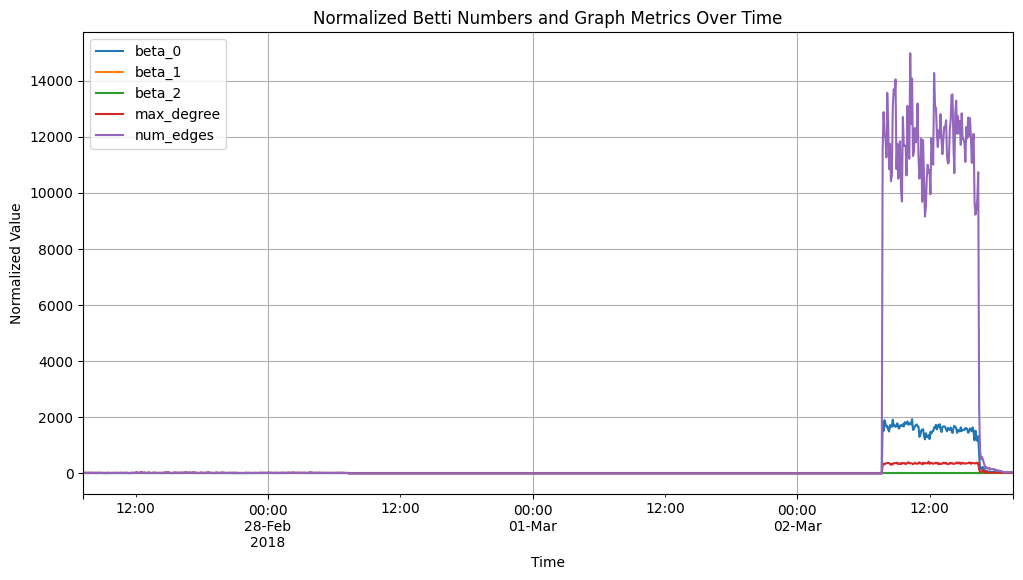

In [ ]:
# Normalize for visualization only
df_plot = df.copy()
for col in ['beta_0', 'beta_1', 'beta_2', 'max_degree', 'num_edges']:
    df_plot[col] = (df_plot[col] - df_plot[col].min()) / (df_plot[col].max() - df_plot[col].min())

df_plot.plot(figsize=(12, 6), title="Normalized Betti Numbers and Graph Metrics Over Time")
plt.ylabel("Normalized Value")
plt.xlabel("Time")
plt.grid(True)
plt.show()

In [42]:
threshold_factor = 1.5  # Start with lower threshold
for col in ['beta_0', 'beta_1', 'beta_2', 'max_degree', 'num_edges']:
    df[f'{col}_mean'] = df[col].rolling(window=window_size, min_periods=1).mean()
    df[f'{col}_std'] = df[col].rolling(window=window_size, min_periods=1).std()
    df[f'{col}_anomaly'] = df[col] > (df[f'{col}_mean'] + threshold_factor * df[f'{col}_std'])

df['BF_XXS_attack'] = df[[f'{col}_anomaly' for col in ['beta_0', 'beta_1', 'beta_2', 'max_degree', 'num_edges']]].any(axis=1)

# Print suspicious windows
print(df[df['BF_XXS_attack']][['beta_0', 'beta_1', 'beta_2', 'max_degree', 'num_edges']])


Empty DataFrame
Columns: [beta_0, beta_1, beta_2, max_degree, num_edges]
Index: []


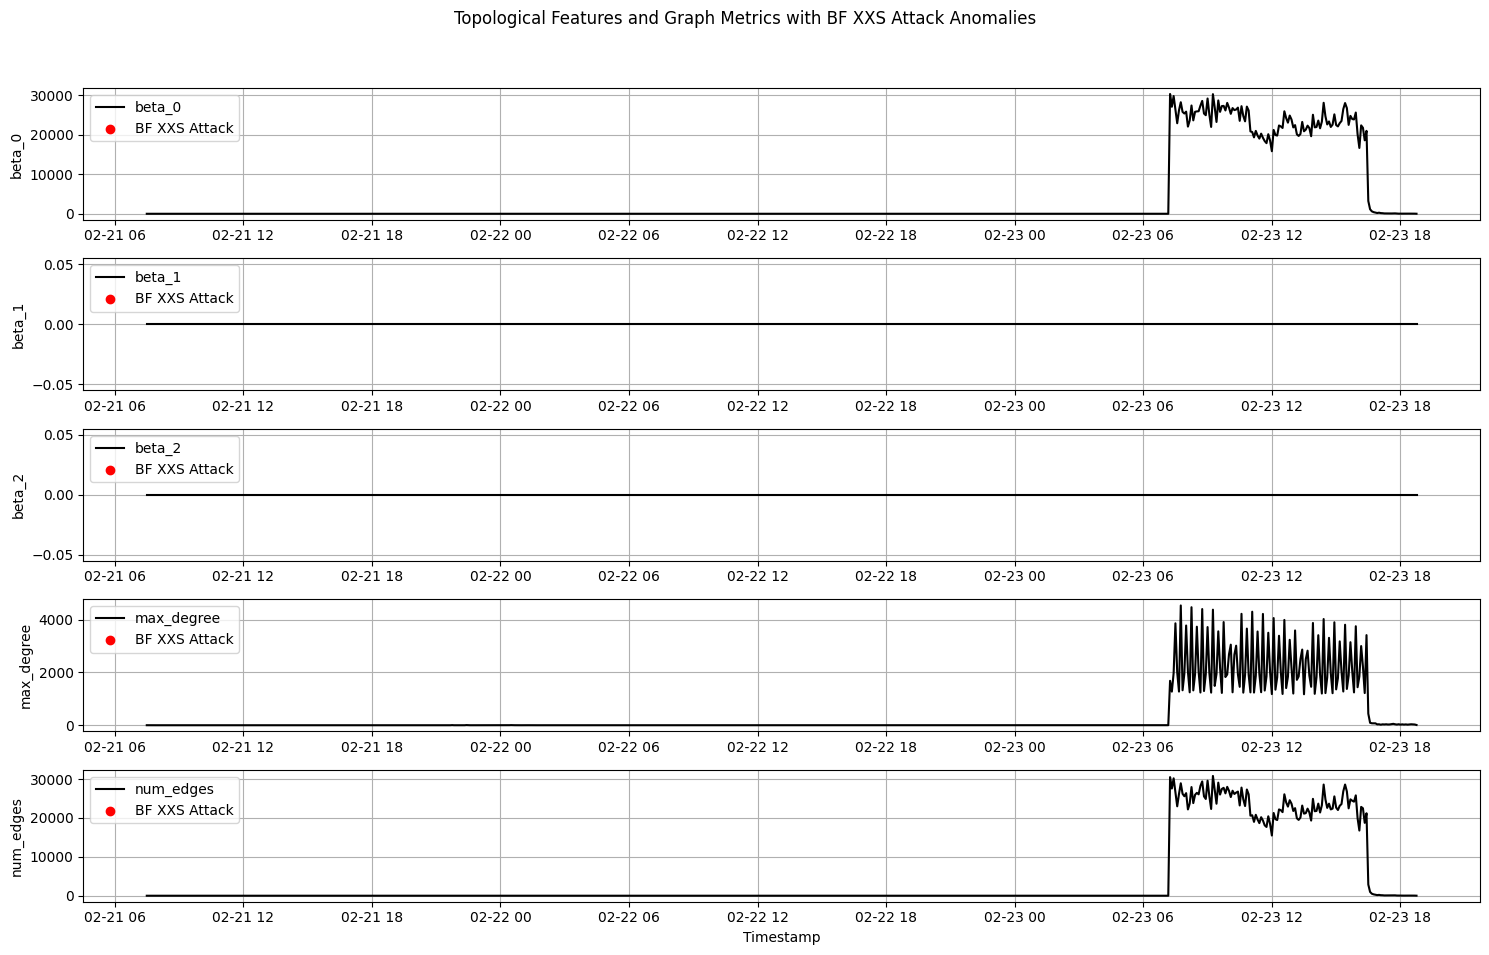

In [43]:
import matplotlib.pyplot as plt

# Plot the key metrics over time
plt.figure(figsize=(15, 10))

# Choose which metrics to plot
metrics_to_plot = ['beta_0', 'beta_1', 'beta_2', 'max_degree', 'num_edges']

for i, col in enumerate(metrics_to_plot, 1):
    plt.subplot(len(metrics_to_plot), 1, i)
    plt.plot(df.index, df[col], label=col, color='black')
    
    # Highlight anomaly points
    anomalies = df[df['BF_XXS_attack']]
    plt.scatter(anomalies.index, anomalies[col], color='red', label='BF XXS Attack', zorder=5)
    
    plt.ylabel(col)
    plt.legend(loc='upper left')
    plt.grid(True)

plt.xlabel('Timestamp')
plt.suptitle('Topological Features and Graph Metrics with BF XXS Attack Anomalies')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Unsupervised anomaly detection

In [ ]:
window = 10
threshold = 3
drift_flags = []

feature_matrix = df[['beta_0', 'beta_1', 'beta_2', 'max_degree', 'num_edges']].values

for i in range(window, len(feature_matrix)):
    baseline = np.median(feature_matrix[i-window:i], axis=0)
    diff = norm(feature_matrix[i] - baseline)
    drift_flags.append(diff > threshold)

df['drift_flag'] = [False]*window + drift_flags


In [22]:
import numpy as np
import gudhi as gd

def betti_from_graph(G, max_dim=2):
    # 1) Build a distance‐matrix from your edge‐weights
    nodes = list(G.nodes())
    n = len(nodes)
    D = np.full((n,n), np.inf)
    np.fill_diagonal(D, 0.0)
    for u, v, d in G.edges(data=True):
        i, j = nodes.index(u), nodes.index(v)
        w = float(d.get("weight", 1.0))
        D[i,j] = D[j,i] = 1.0 / w

    # 2) Choose a max edge‐length so your RipsComplex actually sees edges
    finite = D[np.isfinite(D)]
    if finite.size == 0:
        # empty graph → no edges
        return (G.number_of_nodes(), 0, 0)
    max_len = finite.max()

    # 3) Build the Rips filtration up to dimension max_dim
    rips = gd.RipsComplex(distance_matrix=D, max_edge_length=max_len)
    st   = rips.create_simplex_tree(max_dimension=max_dim)

    # 4) Compute persistence & Betti numbers
    st.compute_persistence()
    b = st.betti_numbers()                 # e.g. [β0], [β0,β1], or [β0,β1,β2]

    # 5) Pad to length max_dim+1 and return exactly (β0, β1, β2)
    b = (b + [0]*(max_dim+1))[:max_dim+1]
    return b[0], b[1], b[2]


# ——— now your loop simply unpacks three ints ———

betti_vectors = []
for t, G in graphs:
    b0, b1, b2 = betti_from_graph(G)        # NO recursion here!
    betti_vectors.append((t, (b0, b1, b2)))

# and you can convert to a DataFrame exactly as before…
